Problem Statement :

"Chocolate Sales Data Analysis"

A mid-sized Chocolate manufacturer is currently experiencing a couple of problems mainly about unpredictable inventory management where it frequently overstocks, declining customer retention and they have discovered that their marketing spending is ineffective.

As a Business Analyst that was employed by the company, they have asked a few questions that you are tasked to answer which is  :

1. What are the key sales trends by product, region and season?
2. Which customer segments are the most or least valuable?
3. How can we forecast demand to optimize production?

The dataset that we will be using is a sample from [kaggle](https://www.kaggle.com/datasets/atharvasoundankar/chocolate-sales) and we are primarly basing this hypothetical problem from this dataset. All credits are given to the one who provides the dataset.

Context for Data Structure

Sales Person 
- Name of the salesperson responsible for the transaction

Country 
- Sales region or store location where the transaction took place

Product
- Name of the Chocolate product sold

Date
- The transaction date of the Chocolate sale

Amount
- Total revenue generated from the sale

Boxes Shipped
- Number of Chocolate boxes shipped in the order

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go

# lOAD RAW DATA
df = pd.read_csv("Chocolate Sales.csv")

# Preview the data

print(df.head())
print(df.dtypes)
print(f"\nData Shape : {df.shape}")
print("\nMissing Values : ")
print(df.isnull().sum())


     Sales Person    Country              Product       Date    Amount  \
0  Jehu Rudeforth         UK      Mint Chip Choco  04-Jan-22   $5,320    
1     Van Tuxwell      India        85% Dark Bars  01-Aug-22   $7,896    
2    Gigi Bohling      India  Peanut Butter Cubes  07-Jul-22   $4,501    
3    Jan Morforth  Australia  Peanut Butter Cubes  27-Apr-22  $12,726    
4  Jehu Rudeforth         UK  Peanut Butter Cubes  24-Feb-22  $13,685    

   Boxes Shipped  
0            180  
1             94  
2             91  
3            342  
4            184  
Sales Person     object
Country          object
Product          object
Date             object
Amount           object
Boxes Shipped     int64
dtype: object

Data Shape : (1094, 6)

Missing Values : 
Sales Person     0
Country          0
Product          0
Date             0
Amount           0
Boxes Shipped    0
dtype: int64


There is no missing values and it seems that all of the data are valid and usable.

There are 1094 rows and 6 columns and it looks like that we will have to change most of the columns data type to their appropriate data types.

In [11]:
# Data Cleaning

# Remove any dollar signs or commas first
df['Amount'] = pd.to_numeric(
    df['Amount'].astype(str).str.replace(r'[^\d.-]', '', regex=True),
    errors='coerce'
)

# Convert to float
df['Amount'] = pd.to_numeric(df['Amount'], errors='coerce')

# Standardize text data
df['Sales Person'] = df['Sales Person'].str.strip().str.title()
df['Country'] = df['Country'].str.strip().str.upper()
df['Product'] = df['Product'].str.strip().str.title()

# Convert dates
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract useful date parts
df['Month'] = df['Date'].dt.month_name()
df['Quarter'] = df['Date'].dt.quarter
df['Day_of_Week'] = df['Date'].dt.day_name()
# Calculate metrics
df['Revenue_Per_Box'] = (df['Amount'] / df['Boxes Shipped']).round(2)

# Save cleaned data
df.to_csv('cleaned_chocolatesales.csv', index=False)
print(df.dtypes)
print(df.head())

Sales Person               object
Country                    object
Product                    object
Date               datetime64[ns]
Amount                      int64
Boxes Shipped               int64
Month                      object
Quarter                     int32
Day_of_Week                object
Revenue_Per_Box           float64
dtype: object
     Sales Person    Country              Product       Date  Amount  \
0  Jehu Rudeforth         UK      Mint Chip Choco 2022-01-04    5320   
1     Van Tuxwell      INDIA        85% Dark Bars 2022-08-01    7896   
2    Gigi Bohling      INDIA  Peanut Butter Cubes 2022-07-07    4501   
3    Jan Morforth  AUSTRALIA  Peanut Butter Cubes 2022-04-27   12726   
4  Jehu Rudeforth         UK  Peanut Butter Cubes 2022-02-24   13685   

   Boxes Shipped     Month  Quarter Day_of_Week  Revenue_Per_Box  
0            180   January        1     Tuesday            29.56  
1             94    August        3      Monday            84.00  
2           

C:\Users\mathe\AppData\Local\Temp\ipykernel_2840\3841526096.py:18: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



After cleaning and making sure that all of the data types are correct then we can proceed on doing data analysis.

We will start by doing some Key Metrics, Top Products and Monthly Trends first.



=== BUSINESS PERFORMANCE ===
Total Revenue: $6,183,625.00
Average Revenue per Box: $34.93
Best Selling Product: 50% Dark Bites

=== CHOCOLATE SALES INSIGHTS ===

1. SEASONAL PATTERNS:
   • Peak month: January ($896,105)
   • Q1 generated 38% of annual revenue

2. PRODUCT PERFORMANCE:
   • Top product: Smooth Sliky Salty ($349,692)
   • Accounts for 6% of total revenue

3. GEOGRAPHIC FOCUS:
   • Largest market: AUSTRALIA ($1,137,367)
   • Average order value: $5548.13

4. OPERATIONAL METRICS:
   • Total boxes shipped: 177,007
   • Revenue per box: $34.93



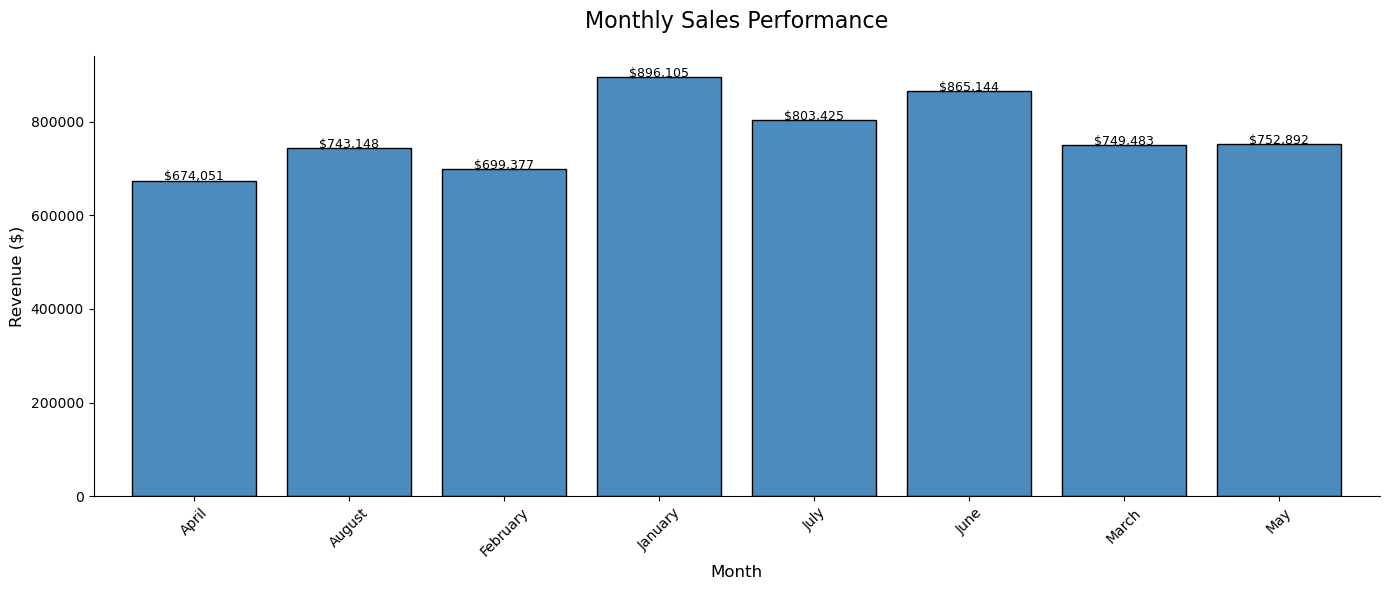

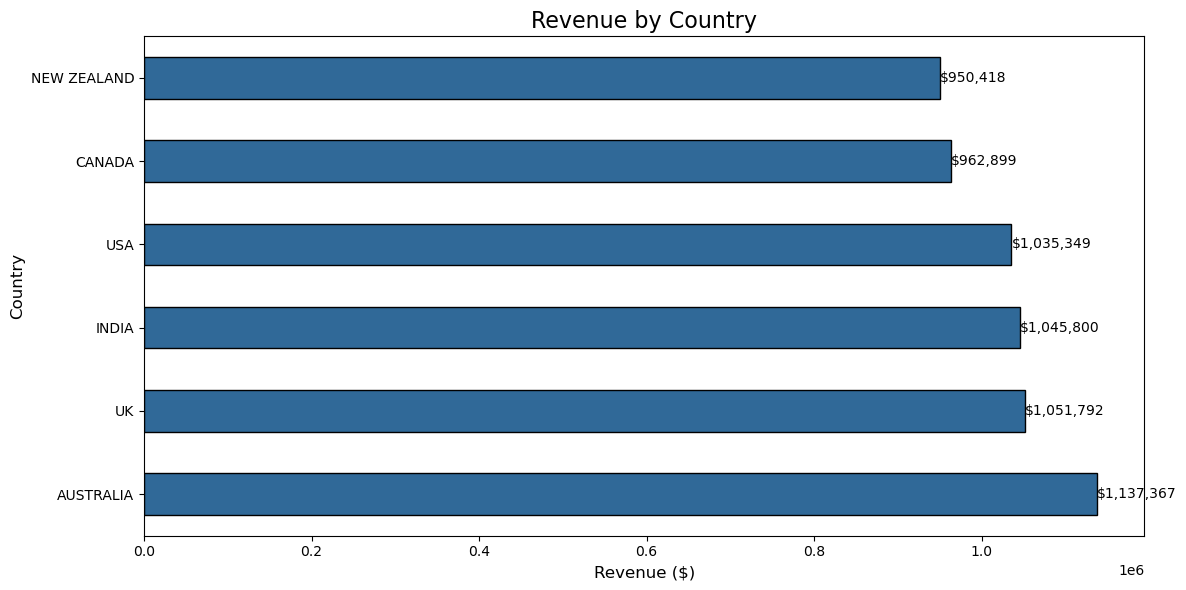

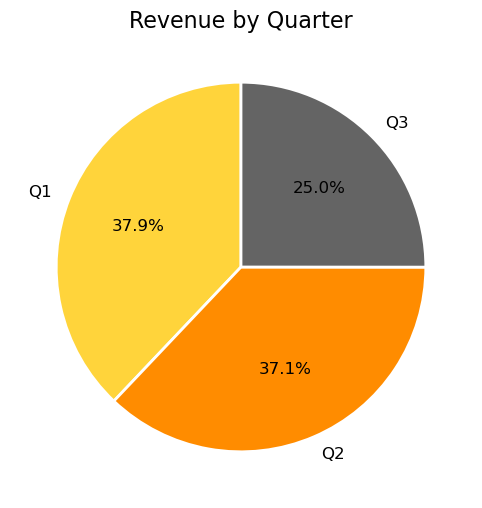

In [12]:
# ===================
# 1. Key Metrics
# ===================
print("=== BUSINESS PERFORMANCE ===")
print(f"Total Revenue: ${df['Amount'].sum():,.2f}")
print(f"Average Revenue per Box: ${df['Amount'].sum()/df['Boxes Shipped'].sum():.2f}")
print(f"Best Selling Product: {df.groupby('Product')['Boxes Shipped'].sum().idxmax()}")

# ===================
# 2. Monthly Sales Trend
# ===================
plt.figure(figsize=(14, 6))
monthly_sales = df.groupby('Month')['Amount'].sum()

# Create bar plot with improved styling
ax = monthly_sales.plot(kind='bar', color='#4B8BBE', edgecolor='black', width=0.8)

# Add value labels
for i, v in enumerate(monthly_sales):
    ax.text(i, v+500, f"${v:,.0f}", ha='center', fontsize=9)

plt.title('Monthly Sales Performance', fontsize=16, pad=20)
plt.ylabel('Revenue ($)', fontsize=12)
plt.xlabel('Month', fontsize=12)
plt.xticks(rotation=45)
sns.despine()
plt.tight_layout()
plt.savefig('monthly_trend.png', dpi=300)

# ===================
# 3. Product Performance
# ===================
top_products = df.groupby('Product').agg({
    'Amount': 'sum',
    'Boxes Shipped': 'sum'
}).sort_values('Amount', ascending=False).head(5)

# Create styled table
product_table = top_products.style\
    .format({'Amount': '${:,.0f}', 'Boxes Shipped': '{:,.0f} units'})\
    .background_gradient(cmap='Blues')\
    .set_caption('Top 5 Products by Revenue')

# ===================
# 4. Geographic Analysis
# ===================
plt.figure(figsize=(12, 6))
country_sales = df.groupby('Country')['Amount'].sum().sort_values(ascending=False)

# Create horizontal bar chart
ax = country_sales.plot(kind='barh', color='#306998', edgecolor='black')
plt.title('Revenue by Country', fontsize=16)
plt.xlabel('Revenue ($)', fontsize=12)
plt.ylabel('Country', fontsize=12)

# Add value labels
for i, v in enumerate(country_sales):
    ax.text(v+200, i, f"${v:,.0f}", va='center', fontsize=10)

plt.tight_layout()
plt.savefig('country_performance.png', dpi=300)

# ===================
# 5. Quarterly Breakdown
# ===================
plt.figure(figsize=(10, 6))
quarter_colors = ['#FFD43B', '#FF8C00', '#646464', '#4B8BBE']
quarter_sales = df.groupby('Quarter')['Amount'].sum()

plt.pie(quarter_sales, 
        labels=[f'Q{q}' for q in quarter_sales.index],
        colors=quarter_colors,
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'edgecolor': 'white', 'linewidth': 2},
        textprops={'fontsize': 12})
plt.title('Revenue by Quarter', fontsize=16)
plt.savefig('quarterly_breakdown.png', dpi=300)

# ===================
# 6. Key Insights Report
# ===================
peak_month = monthly_sales.idxmax()
top_country = country_sales.idxmax()
top_product = top_products.index[0]

insights = f"""
=== CHOCOLATE SALES INSIGHTS ===

1. SEASONAL PATTERNS:
   • Peak month: {peak_month} (${monthly_sales.max():,.0f})
   • Q{quarter_sales.idxmax()} generated {quarter_sales.max()/quarter_sales.sum():.0%} of annual revenue

2. PRODUCT PERFORMANCE:
   • Top product: {top_product} (${top_products.loc[top_product]['Amount']:,.0f})
   • Accounts for {top_products.loc[top_product]['Amount']/df['Amount'].sum():.0%} of total revenue

3. GEOGRAPHIC FOCUS:
   • Largest market: {top_country} (${country_sales[top_country]:,.0f})
   • Average order value: ${df[df['Country']==top_country]['Amount'].mean():.2f}

4. OPERATIONAL METRICS:
   • Total boxes shipped: {df['Boxes Shipped'].sum():,}
   • Revenue per box: ${df['Amount'].sum()/df['Boxes Shipped'].sum():.2f}
"""

print(insights)

For the insights that we generated, we can see that there is no 4th Quarter and we can check in the cleaned data that there is no records of Chocolates Sales made in the 4th Quarter at all.

We will be showing the insights for the 1st to 3rd Quarter and the key insights are :

1. Revenue Trends & Marketing Allocation
- Generated $6.18M annually, with Q1 (Jan-Mar) contributing 38% of total revenue.
- Recommendation: Allocate 40% of next year’s marketing budget to Q1 to capitalize on peak demand.

2. Product Performance
- Top Revenue Driver: Smooth Sliky Salty (6% of annual revenue).
- Top Volume Seller: 50% Dark Bites (highest units sold).
- Recommendation: Launch a premium version of Smooth Sliky Salty (e.g., flavor-enhanced or artisan ingredients) to increase average order value.

3. Geographic Opportunity
- Australia drove 18.4% of revenue ($1.14M)—the highest among all markets.
- Recommendation: Create localized bundles pairing best-sellers with Australian-made ingredients to boost regional sales.

Strategic Next Steps
- Run early-bird discounts in Q1 to incentivize purchases during peak season.
- Develop an Australia-focused loyalty program to stregthen regional sales.